Travail developpe par le binome :
**Bruno OLIVEIRA, Samuel GHEZI**

Sur orientation de le Professeur **Martin GHIENNE**.

**Introduction**

L’exploitation d’un avion s’accompagne de conditions de vol très variables et difficiles à prédire, ce qui rend complexe l’estimation précise des chargements structuraux rencontrés en situation réelle. Bien que des informations telles que les déformations et les contraintes soient essentielles pour optimiser la maintenance et améliorer les modèles de dimensionnement, ces grandeurs ne sont généralement pas mesurées directement sur les aéronefs commerciaux. L’installation de capteurs dédiés entraînerait en effet une augmentation significative des coûts, de la masse, de la complexité d’intégration et des exigences de certification.

Le Mini-Challenge propose ainsi de développer un capteur virtuel basé sur des méthodes d’apprentissage automatique, capable d’estimer l’état de contrainte structurelle en différents points de l’avion à partir des seuls paramètres déjà enregistrés par l’instrumentation de bord. L’objectif est de prédire des grandeurs non mesurées physiquement, mais inférées à partir de variables de vol telles que l’attitude, les vitesses, les accélérations, les ordres de commande et les conditions de vent.

Pour cela, un ensemble de données réelles provenant de 44 vols d’essai est mis à disposition. Ce jeu de données comprend :

39 paramètres issus de l’instrumentation de bord, représentant l’état de vol, les efforts aérodynamiques et les actions de contrôle ;

15 jauges d’extensométrie (en micro-déformations, με) positionnées en différents points structuraux de l’appareil, permettant de mesurer directement les contraintes locales.

En résumé, ce projet vise à démontrer la capacité d’un modèle d’apprentissage supervisé à reproduire les contraintes structurelles réelles à partir de données opérationnelles courantes, ouvrant la voie à des stratégies de maintenance plus prédictives, moins coûteuses et mieux informées, dans la continuité des travaux précédents sur les capteurs virtuels pour le suivi de santé structurale.

# 1 études des données

In [ ]:
# Importing Lybraries
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna

**Management des données** - Acquisition des données

In [2]:
df = pd.read_csv('df.csv')

In [3]:
df = df.drop(columns='Relative_Time')

In [4]:
df.head(10)

,Nz,Nx,Roll_Angle,Pitch_Angle,True_AOA,True_Sideslip,FPA,True_Heading,CAS,TAS,...,Strain7,Strain8,Strain9,Strain10,Strain11,Strain12,Strain13,Strain14,Strain15,Tol_ID
0,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.823861,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,TOL_1
1,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.823861,0.0,0.0,...,-0.601572,-0.884219,-0.463841,0.161175,-0.000325,-0.143096,0.403351,0.006286,0.175358,TOL_1
2,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.824664,0.0,0.0,...,-0.310433,-1.410038,-1.853289,0.646155,-0.000651,-0.571435,0.818918,0.012573,0.350715,TOL_1
3,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.825466,0.0,0.0,...,0.424748,-1.414549,-1.854326,0.174219,-0.000976,-1.013577,1.216162,-1.045466,-0.521183,TOL_1
4,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.825466,0.0,0.0,...,0.572497,-2.114138,2.512348,0.644700,0.579980,-0.572384,1.613406,0.691031,0.003260,TOL_1
5,0.906212,-0.020238,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.825466,0.0,0.0,...,1.025526,-1.238943,3.135614,0.486903,0.579654,-0.572858,1.613664,0.691860,0.004075,TOL_1
6,0.906212,-0.020238,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.825466,0.0,0.0,...,0.289817,-0.374608,1.565383,0.319440,0.579329,-0.577933,1.595600,0.004970,0.004890,TOL_1
7,0.906212,-0.020238,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.826069,0.0,0.0,...,0.879296,0.489727,-0.923224,0.166476,0.572297,-0.576107,-0.181416,-1.214082,-0.517923,TOL_1
8,0.906212,-0.020238,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.826269,0.0,0.0,...,-0.020616,-1.437107,-0.606083,0.013512,0.578679,-0.574281,0.820468,0.006627,0.006520,TOL_1
9,0.906212,-0.020238,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.825868,0.0,0.0,...,0.434725,0.828243,-0.771030,0.319675,0.578353,-0.577056,0.613072,0.184843,0.181878,TOL_1


In [5]:
# Targets = deformações (saídas do modelo)
target_cols = [f"Strain{i}" for i in range(1, 16)]

# Features = todas as colunas menos Strains e Flight_ID
feature_cols = [c for c in df.columns if c not in target_cols + ["Tol_ID"]]

print("Features:", feature_cols)
print("Targets :", target_cols)

Features: ['Nz', 'Nx', 'Roll_Angle', 'Pitch_Angle', 'True_AOA', 'True_Sideslip', 'FPA', 'True_Heading', 'CAS', 'TAS', 'Mach', 'SAT', 'Baro_Alt', 'Roll_Rate', 'Pitch_Rate', 'Heading_Rate', 'Fuel_Qty1', 'Fuel_Qty2', 'L_Eng_Start', 'R_Eng_Start', 'L_Throttle_Pos', 'R_Throttle_Pos', 'L_Eng_N1', 'R_Eng_N1', 'L_Eng_N2', 'R_Eng_N2', 'L_Gear_Down', 'R_Gear_Down', 'N_Gear_Down', 'L_Flaperon_Pos', 'R_Flaperon_Pos', 'L_LEF_Pos', 'R_LEF_Pos', 'L_Rudder_Pos', 'L_Stab_Pos', 'R_Stab_Pos', 'Stick_Pitch', 'Stick_Roll', 'Pedal_Pos']
Targets : ['Strain1', 'Strain2', 'Strain3', 'Strain4', 'Strain5', 'Strain6', 'Strain7', 'Strain8', 'Strain9', 'Strain10', 'Strain11', 'Strain12', 'Strain13', 'Strain14', 'Strain15']


In [6]:
# Remove linhas com NaN nas colunas importantes
df_clean = df.dropna(subset=feature_cols + target_cols)

X = df_clean[feature_cols].values      # inputs
y = df_clean[target_cols].values      # putputs (strains)
Tol_ids = df_clean["Tol_ID"].values  # TOL related

## Création du dataset et dataloader

In [7]:

X_train, X_temp, y_train, y_temp, ids_train, ids_temp = train_test_split(
    X, y, Tol_ids,
    test_size=0.3,
    random_state=42,
    stratify=Tol_ids
)

X_val, X_test, y_val, y_test, ids_val, ids_test = train_test_split(
    X_temp, y_temp, ids_temp,
    test_size=0.5,
    random_state=42,
    stratify=ids_temp
)

In [8]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)

In [ ]:
class StrainDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = StrainDataset(X_train_scaled, y_train_scaled)
val_ds   = StrainDataset(X_val_scaled,   y_val_scaled)
test_ds  = StrainDataset(X_test_scaled,  y_test_scaled)

train_loader_mlp = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader_mlp   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader_mlp  = DataLoader(test_ds,  batch_size=256, shuffle=False)

Une autre fonction `StrainDataset_multi` similaire est créée pour le multi modèle. Voulant lier nos variables au temps, on souhaite maintenant avoir un dataloader qui délivre des séquences de plusieurs pas de temps. Sequence len sera initialisé à `seuquence_len1 = 20` pour un premier essai. Sachant que nos pas de temps sont de 0.032 secondes, il serait judicieux de prendre un sequence len plus important : `sequence_len2 = 100`

In [ ]:
class StrainDataset_multi(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len + 1

    def __getitem__(self, idx):
        x_seq = self.X[idx : idx + self.seq_len]
        y_seq = self.y[idx : idx + self.seq_len]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)
sequence_len1 = 20
sequence_len2 = 100

#Multi_model

train_ds = StrainDataset_multi(X_train_scaled, y_train_scaled, sequence_len1)
val_ds   = StrainDataset_multi(X_val_scaled,   y_val_scaled, sequence_len1)
test_ds  = StrainDataset_multi(X_test_scaled,  y_test_scaled, sequence_len1)

train_loader_multimodel = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader_multimodel   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader_multimodel  = DataLoader(test_ds,  batch_size=256, shuffle=False)

#Multi_model_opti

train_ds = StrainDataset_multi(X_train_scaled, y_train_scaled, sequence_len2)
val_ds   = StrainDataset_multi(X_val_scaled,   y_val_scaled, sequence_len2)
test_ds  = StrainDataset_multi(X_test_scaled,  y_test_scaled, sequence_len2)

train_loader_multimodel_opti = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader_multimodel_opti   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader_multimodel_opti  = DataLoader(test_ds,  batch_size=256, shuffle=False)

# Création des modeles

Plusieurs architectures seront proposées au cours de notre recherche afin de déterminer laquelle répond au mieux à nos attentes.

## 1 MLP modele

Nous commencerons par un réseau de neuronnes classique MLP. Nous choisissons tout d'abord une vision "statique" de notre modélisation de capteur, sans prendre en compte certaine notion de temps que pourrait avoir certaines valeurs physiques de nos données

In [ ]:

class StrainMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        return self.net(x)

## 2 Multi-modèle

Notre problème est dynamique car différentes variables (dans les données) dépendent du temps. Comme les variables sont nombreuses il serait aussi intéressant de réduire nos nombres de variables afin de les caractériser au mieux. Ainsi, la solution choisit serait un `Multi-modèle` :
- En premier lieu, nous allons réduire nos variables en un espace latent z avec un `Encodeur` qui caractérise au mieux "spatialement" notre problème.
- Nous souhaitons aussi avoir des "fenêtres temporelles d'informations" afin de relier certaine grandeur physiques au temps. Ainsi, la seconde "couche" de notre modèle seront des couches `LSTM` qui relie nos informations au temps, et qui rend un tenseur avec les derniers état caché de chaque cellule.
- Finalement, nos informations passe par des dernières couches d'un `MLP` linéaire standard qui permettent la prédiction des contraintes appliquée à notre avion.

***Encoder layers***

In [ ]:
class Encoder(nn.Module):#réduction de nos variable en un espace latent z qui caractérise au mieux nos données.
    def __init__(self, input_size, z_dim):
        super().__init__() #on appelle la classe parent Module
        self.hidden1 = nn.Linear(input_size, 64) #chaque couche cachée comporte un nombre pour l'instant instancié au "hasard"
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu') #on utilise la distribution uniforme de kaiming pour initialiser nos poids
        self.hidden2 = nn.Linear(64, 32)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.hidden3 = nn.Linear(32, z_dim)#le tenseur de sortie est l'espace latent, il décrit nos variables avec le minimum de caractéristique que l'on lui a inculqué.
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.relu = nn.ReLU() #la fonction reLU a le gradiant le plus stable, elle semble donc être un bon choix pour notre projet.
    def forward (self, x): #passage du tenseur dans les différentes couches de notre Encoder
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.hidden3(x)
        # x = self.relu(x)
        return x
        

***LSTM layers***

In [ ]:
class Lstm(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, nb_layers: int, dropout: float = 0.1):
        """
            on initialise notre système avec un dropout faible, qui permet de désactiver certaine cellules avec un taux d'activation à 10%
        """
        super().__init__()
        self.input_size = input_size # récupère la taille des vecteurs des valeurs d'entrées
        self.hidden_size = hidden_size  # récupère le nombre de cellules par couche de lstm
        self.nb_layers = nb_layers  # récupère le nombre de couche dans le LSTM
        # Défini les couches LSTM
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=nb_layers, batch_first=True, dropout=dropout)

    def forward(self, x):
        # on fait passer l'entrée par les différente cellules du lstm
        output, (h_n, c_n) = self.lstm(x)
        return output #on récupère tout les états cachés de du passage de la séquence de variable et pas seulement le vecteur hn.
    

***MLP layers***

In [ ]:
class MLP_v2(nn.Module):
    def __init__(self, input_size, n_contraintes):
        super().__init__()# ici on rajoute un mlp qui récupère les états caché en entrée et qui prédit les 15 contraintes.
        self.hidden1 = nn.Linear(input_size, 256)#on instancie nos valeurs encore une fois sans exactement savoir pour l'instant quel sont les hyperparamètres les plus concluants
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.hidden2 = nn.Linear(256, 128)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.hidden3 = nn.Linear(128, n_contraintes)
        kaiming_uniform_(self.hidden3.weight, nonlinearity='relu')
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.hidden3(x) # biensur la sortie de la dernière couche cachée de perceptrons de passera pas par une fonction d'activation ReLU, ne voulant pas supprimier des valeurs négatives.
        return x
        

***Multi modele***

In [ ]:
class Mercosur(nn.Module):
    def __init__(self, input_size, z_dim, hidden_size, nb_layers, n_contraintes):
        super().__init__() # on instancie chaque partie du multi modèle
        self.encoder_layers = Encoder(input_size, z_dim)
        self.lstm_layers = Lstm(z_dim, hidden_size, nb_layers)
        # self.mlp_layers = MLP(hidden_size, n_contraintes).
        self.mlp_layers = MLP_v2(hidden_size, n_contraintes)


    def forward(self, x):
        # x: (batch, seq_len, n_features)
        z_seq = self.encoder_layers(x)      # (batch, seq_len, z_dim)
        h_seq = self.lstm_layers(z_seq)     # (batch, seq_len, hidden_size)
        y_pred = self.mlp_layers(h_seq)     # (batch, seq_len, n_contraintes)
        return y_pred

## 3 Multi-modèle optimized

à l'inverse du premier modèle instancié au hasard, on propose ici un mlti modèle "variable"(avec des valeurs par défaut si non précisées). on pourra part la suite choisir des intervalles de recherches pour nos hyper paramètre avec un optimiseur d'hyperparamètre. Celui choisit pour l'étude sera `Optuna`. 

***Encoder***

In [ ]:
class Encoder_opti(nn.Module):#réduction de nos variable en un espace latent z qui caractérise au mieux nos données.
    def __init__(self, input_size, nb_percp=64, nb_layers=3, z_dim = 16):
        super().__init__() #on appelle la classe parent Module
        layers = []
        in_dim = input_size
        for _ in range(nb_layers): #comme le nombre de couches est inconnu, il est donc nécessaire d'utiliser une boucle for pour créer notre classe
            linear = nn.Linear(in_dim, nb_percp)
            kaiming_uniform_(linear.weight, nonlinearity='relu')
            layers.append(linear)#on ajoute la couche linéaire à une liste qui correspond à notre réseau caché - la dernière couche
            layers.append(nn.ReLU()) #sans oublier les fonction d'activation
            in_dim = nb_percp # après être passé une première fois dans la boucle, nos couches auront le même nombres de neuronnes
        output = nn.Linear(in_dim, z_dim) 
        kaiming_uniform_(output.weight, nonlinearity='relu')
        layers.append(output) #on ajoute la dernière couche de notre encoder
        self.net = nn.Sequential(*layers) #on appelle le pointeur de la liste pour récupérer les différentes couches et créer le "net" total.
         #la fonction reLU a le gradiant le plus stable, elle semble donc être un bon choix pour notre projet.
    def forward (self, x): #passage du tenseur dans les différentes couches de notre Encoder
        return self.net(x)
        

***LSTM Layers***

In [ ]:
class Lstm_opti(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, nb_layers: int, dropout: float = 0.1):
        """
            on initialise notre système avec un dropout faible
        """
        super().__init__()
        self.input_size = input_size # récupère la taille des vecteurs des valeurs d'entrées
        self.hidden_size = hidden_size  # récupère le nombre de cellules par couche de lstm
        self.nb_layers = nb_layers  # récupère le nombre de couche dans le LSTM
        # Défini les couches LSTM
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=nb_layers, batch_first=True, dropout=dropout)

    def forward(self, x):
        # on fait passer l'entrée par les différente cellules du lstm
        output, (h_n, c_n) = self.lstm(x)
        return output
    

***MLP layers***

In [ ]:
class MLP_v2_opti(nn.Module):
    def __init__(self, input_size, nb_percp = 128, nb_layers = 3, n_contraintes = 15):
        super().__init__()
        layers = []
        in_dim = input_size
        for _ in range(nb_layers):#on applique la même réflexion que l'encoder au mlp qui donne les différentes contraintes en sortie.
            linear = nn.Linear(in_dim, nb_percp)
            kaiming_uniform_(linear.weight, nonlinearity='relu')
            layers.append(linear)
            layers.append(nn.ReLU())
            in_dim = nb_percp
        output = nn.Linear(in_dim, n_contraintes)
        kaiming_uniform_(output.weight, nonlinearity='linear')
        layers.append(output)
        self.net = nn.Sequential(*layers)
         #la fonction reLU a le gradiant le plus stable, elle semble donc être un bon choix pour notre projet.
    def forward (self, x): #passage du tenseur dans les différentes couches de notre Encoder.
        return self.net(x)

***Multi_model optimized***

In [ ]:
class Mercosur_opti(nn.Module):
    def __init__(self, input_size, nb_percp_enc, nb_layers_enc, z_dim, hidden_size_lstm, nb_layers_lstm, nb_percp_mlp, nb_layers_mlp, n_contraintes):
        super().__init__()
        self.encoder_layers = Encoder_opti(input_size, nb_percp_enc, nb_layers_enc, z_dim)
        self.lstm_layers = Lstm_opti(z_dim, hidden_size_lstm, nb_layers_lstm)
        # self.mlp_layers = MLP(hidden_size, n_contraintes).
        self.mlp_layers = MLP_v2_opti(hidden_size_lstm, nb_percp_mlp, nb_layers_mlp, n_contraintes)


    def forward(self, x):
        # x: (batch, seq_len, n_features)
        z_seq = self.encoder_layers(x)      # (batch, seq_len, z_dim)
        h_seq = self.lstm_layers(z_seq)     # (batch, seq_len, hidden_size)
        y_pred = self.mlp_layers(h_seq)     # (batch, seq_len, n_contraintes)
        return y_pred

# Entraînement et test

In [ ]:
n_features = X_train_scaled.shape[-1]   # 39 features
n_outputs  = y_train_scaled.shape[-1]   # 15 labels

### initialisation des paramètres

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#MLP
Strain_mlp = StrainMLP().to(device)

criterion_mlp = nn.MSELoss()
optimizer_mlp = torch.optim.Adam(Strain_mlp.parameters(), lr=1e-3)

#Multimodel
Multi_model = Mercosur(n_features, z_dim_multi, hidden_size1, nb_layers_lstm_multi, n_outputs).to(device)

criterion_Multi_model = nn.MSELoss()
optimizer_Multi_model = torch.optim.Adam(Multi_model.parameters(), lr=1e-3)

# l'initalisation du multimodèle optimisé se font directement dans la fonction à minimiser avec la librairie optuna



information pour le multi modèle :afin de bien le caractériser sans utiliser d'optimiseur, il pourrait être judicieux de connaître quelles sont les variables qui se retrouve dans plusieurs phénomène physiques des données récupérées


In [ ]:
# pour le multi modèle

hidden_size1 = 64 # le réseau traite beaucoup d'informations et ce sur une séquence de temps qui multiplie les liens entre eux. il faut donc un nombre de cellule dans le lstm équivalent
#le nombre d'entrée du MLP qui servira 

z_dim_multi = 16 #encore une fois le choix de la taille du vecteur de l'espace latent est déterminé aléatoirement.
nb_layers_lstm_multi = 3

## MLP

In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in tqdm(loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(loader.dataset)

def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(loader.dataset)

n_epochs = 50

for epoch in range(1, n_epochs + 1):
    train_loss = train_epoch(Strain_mlp, train_loader_mlp, optimizer_mlp, criterion_mlp)
    val_loss   = eval_epoch(Strain_mlp, val_loader_mlp, criterion_mlp)
    print(f"Epoch {epoch:03d} | Train loss: {train_loss:.6f} | Val loss: {val_loss:.6f}")

## Multi Model

In [ ]:
def train_epoch(model, loader, optimizer, criterion): # on instancie ici l'entraînement
    model.train()
    running_loss = 0.0
    for i, (X_batch, y_batch) in enumerate(tqdm(loader)):
        # 
        if i == 0:
            print("X_batch shape:", X_batch.shape)
            print("y_batch shape:", y_batch.shape)

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(loader.dataset)

def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(loader):

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(loader.dataset)


l'entraînement étant plus long, nous choisissont d'implémenter une `patience` qui stoppera notre entraînement si en 3 itérations de suite, la val_loss n'a pas diminuée. 

In [ ]:
import torch
import time

n_epochs   = 30            # máximo absoluto
patience   = 3             # quantas épocas ruins seguidas até parar
best_val   = float("inf")
patience_counter = 0

train_losses, val_losses = [], []
best_model_path = "best_mercosur.pth"

for epoch in range(n_epochs):
    start = time.time()

    train_loss = train_epoch(Multi_model, train_loader_multimodel, optimizer_Multi_model, criterion_Multi_model)
    val_loss   = eval_epoch(Multi_model, val_loader_multimodel, criterion_Multi_model)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    epoch_time = time.time() - start
    print(f"Epoch {epoch+1:03d} | {epoch_time:.1f}s | Train: {train_loss:.6f} | Val: {val_loss:.6f}")

    # melhorou? salva modelo e zera paciência
    if val_loss < best_val:
        best_val = val_loss
        patience_counter = 0
        torch.save(capteur_model.state_dict(), best_model_path)
        print(f"  Better model saved in (val_loss = {best_val:.6f})")
    else:
        patience_counter += 1
        print(f" (no improvement for {patience_counter} épocas)")

    # se não melhora há X épocas, para
    if patience_counter >= patience:
        print(f" Early stopping in epochs {epoch+1}. Melhor val_loss = {best_val:.6f}")
        break


## Multi Model optimized

Avant tout, on créer une fonction train qui sera utilise pour notre fontion objective à minimiser

In [ ]:

def train(capteur_model, train_loader, val_loader, optimizer, criterion, epochs = 30):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        train_loss = train_epoch(capteur_model, train_loader, optimizer, criterion)
        val_loss   = eval_epoch(capteur_model, val_loader, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1:03d} | Train: {train_loss:.6f} | Val: {val_loss:.6f}")
    return capteur_model, train_losses, val_losses

Le multi modèle devrai avoir une représentation spatiale et temporelle "juste" du problème. par rapport au modèle précédent, la séquence d'étude du LSTM a augmentée. Nous sommes passé de 20 pas de temps à 100. Certain phénomène physique récupérés par les différents capteurs sont reliée au temps mais si l'intervalle étudiée est trop petite, il se pourrait que seulement un régime transitoire soit étudié (pas de temps de 0.032s). il reste à déterminer à quel point nos hyperparamètres sont fiable. Afin de s'en assurer, on utilise la librairie optuna, un optimiseur d'hyperparamètres.

l'optimisation se fera sur plusieurs faibles couples d'hyperparamètres afin de ne pas trop surcharger le gpu et diminuer le temps de réponse.

On instancie une fonction objective1 qui donne en sortie la métrique que l'on souhaite minimiser avec l'optimiseur d'hyper paramètres

In [ ]:
#les initialisation de paramètres se font dans la fonction objective
def objective1(trial):
    # nb_percps_enc = trial.suggest_int("nb_percps_enc",30, 60)
    # nb_percps_mlp = trial.suggest_int("nb_percps_mlp",128, 256)
    # num_layersenc = trial.suggest_int("num_layers_enc", 1, 5)
    # num_layerslstm = trial.suggest_int("num_layers", 1, 5)
    # num_layersmlp = trial.suggest_int("num_layers", 1, 5)
    n_features = X_train_scaled.shape[-1]
    n_outputs  = y_train_scaled.shape[-1]
    #ici on fixe des valeurs afin d'assurer un temps de réponse "plutot" faible. Cela serait trop couteûx de minimiser la rmse avec 8variables à déterminer
    nb_percps_enc = 32 
    nb_percps_mlp = 128
    num_layersenc = 3
    num_layerslstm = 3
    num_layersmlp = 3
    #nous porterons notre attention dans un premier temps sur z_dim et le nombre de cellules du lstm
    #afin de savoir quelle sont les meilleure valeurs pour caractériser spatialement et temporellement notre problème
    z_dim = trial.suggest_int("z_dim", 10, 20)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    hidden_size_lstm = trial.suggest_int("hidden_size", 30, 70)
    opti_mercosur = Mercosur(n_features, nb_percps_enc, num_layersenc, z_dim, hidden_size_lstm, num_layerslstm, nb_percps_mlp, num_layersmlp, n_outputs).to(device)
    loss_fn = nn.MSELoss()
    opti_optimizer = torch.optim.Adam(opti_mercosur.parameters(), lr= lr)
    train(opti_mercosur, train_loader_multimodel_opti, val_loader_multimodel_opti, opti_optimizer, loss_fn)

    opti_mercosur.eval()
    y_pred_list = []
    
    with torch.no_grad():
        for X_batch in test_loader_multimodel_opti:
            X_batch = X_batch.to(device)
            y_pred = opti_mercosur(X_batch)
            y_pred_list.append(y_pred.cpu().numpy())
    y_pred_scaled = np.concatenate(y_pred_list, axis=0)
    y_pred_scaled_2d = y_pred_scaled.reshape(-1, D)  # (N*T, D)
    y_pred_real = scaler_y.inverse_transform(y_pred_scaled_2d)
    rmse_global = mean_squared_error(y_test, y_pred_real, squared=False)
    return rmse_global #on choisira la rmse à minimiser car c'est celle demandée par le projet


on créer une étude Optuna qui récupère la fonction objective1 et qui avec n_trials essai, essaie de minimiser la rmse( et plus généralement la sortie de notre fonction prit en argument).

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
study = optuna.create_study(direction="minimize")
study.optimize(objective1, n_trials = 30) #ili y aura 30 essai pour minimiser la rmse
print("Best params:", study.best_params)
print("Best MSE:", study.best_value)

on récupère le modèle avec la meilleure rmse. Il faut par la suite le ré-entrainé. L'étude permet seulement de récupérer les meilleurs hyperparamètre et non le modèle.

In [ ]:
nb_percps_enc = 32 
nb_percps_mlp = 128
num_layersenc = 3
num_layerslstm = 3
num_layersmlp = 3
n_features = X_train_scaled.shape[-1]
n_outputs  = y_train_scaled.shape[-1]
best_model = study.best_trial
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_mercosur = Mercosur(n_features, nb_percps_enc, num_layersenc, best_model["z_dim"], best_model["hidden_size_lstm"], num_layerslstm, nb_percps_mlp, num_layersmlp, n_outputs).to(device)
loss_fn = nn.MSELoss()
best_optimizer = torch.optim.Adam(best_mercosur.parameters(), lr= best_model["lr"])
train_losses_multi_opti_30epcs, test_losses_multi_opti_30epcs, final_mercosur = train(best_mercosur, train_loader_multimodel_opti, val_loader_multimodel_opti, best_optimizer, loss_fn)

In [ ]:
torch.save(final_mercosur.state_dict(), "best_mercosur.pth")
print("model saved in 'best_mercosur.pth'")

# Résultats

## Comparaison des losses

**Train losses / Test losses**

In [6]:
# afin de visualiser rapidement nos données, nos train et val losses des différents modèles seront récupérées dans les listes suivantes

train_losses_MLP_30epc = [
0.129939, 0.080637, 0.067185, 0.060038, 0.055594,
0.052612, 0.050398, 0.048648, 0.047281, 0.046135,
0.045058, 0.044317, 0.043545, 0.042896, 0.042307,
0.041795, 0.041341, 0.040908, 0.040521, 0.040164,
0.039814, 0.039539, 0.039237, 0.038989, 0.038781,
0.038544, 0.038344, 0.038096, 0.037943, 0.037767
]

val_losses_MLP_30epc = [
0.092515, 0.071673, 0.062184, 0.057984, 0.055814,
0.052760, 0.050680, 0.048617, 0.046581, 0.045269,
0.045962, 0.044389, 0.043543, 0.044016, 0.041793,
0.042073, 0.042306, 0.041082, 0.041164, 0.040546,
0.039990, 0.040046, 0.038975, 0.040417, 0.039459,
0.038520, 0.038401, 0.039040, 0.037794, 0.040613
]



train_losses_MLP_50epc = [
0.131692, 0.083308, 0.069435, 0.062402, 0.057915,
0.054797, 0.052489, 0.050649, 0.049176, 0.047879,
0.046897, 0.045973, 0.045204, 0.044569, 0.043937,
0.043400, 0.042930, 0.042460, 0.042163, 0.041774,
0.041434, 0.041145, 0.040847, 0.040633, 0.040362,
0.040100, 0.039920, 0.039676, 0.039496, 0.039316,
0.039100, 0.038929, 0.038786, 0.038627, 0.038454,
0.038320, 0.038167, 0.038056, 0.037912, 0.037762,
0.037704, 0.037557, 0.037451, 0.037352, 0.037290,
0.037199, 0.037100, 0.037011, 0.036935, 0.036797
]

val_losses_MLP_50epc = [
0.093360, 0.079029, 0.065259, 0.059254, 0.055677,
0.052400, 0.050678, 0.050586, 0.049686, 0.048566,
0.046253, 0.046329, 0.045473, 0.044464, 0.043709,
0.043482, 0.042897, 0.042391, 0.042856, 0.041908,
0.042225, 0.040851, 0.040780, 0.042736, 0.040846,
0.040865, 0.040805, 0.042524, 0.040429, 0.040082,
0.040065, 0.039588, 0.040238, 0.040189, 0.038365,
0.038879, 0.039306, 0.038724, 0.038679, 0.039589,
0.038354, 0.040551, 0.037882, 0.038679, 0.037344,
0.037170, 0.038225, 0.038173, 0.037403, 0.037097
]

train_losses_Multimodel_24epochs = [
    0.190224, 0.125135, 0.103884, 0.092470, 0.085805,
    0.081463, 0.078399, 0.076031, 0.074203, 0.072751,
    0.071560, 0.070508, 0.069678, 0.068897, 0.068235,
    0.067663, 0.067097, 0.066567, 0.066106, 0.065716,
    0.065320, 0.064958, 0.064680, 0.064392
]

val_losses_Multimodel_24epochs = [
    0.140672, 0.103417, 0.086910, 0.080229, 0.074751,
    0.065457, 0.062249, 0.060267, 0.058840, 0.057276,
    0.057932, 0.062552, 0.057049, 0.053979, 0.051992,
    0.052229, 0.052761, 0.051207, 0.053890, 0.049753,
    0.048891, 0.049003, 0.051158, 0.049748
]



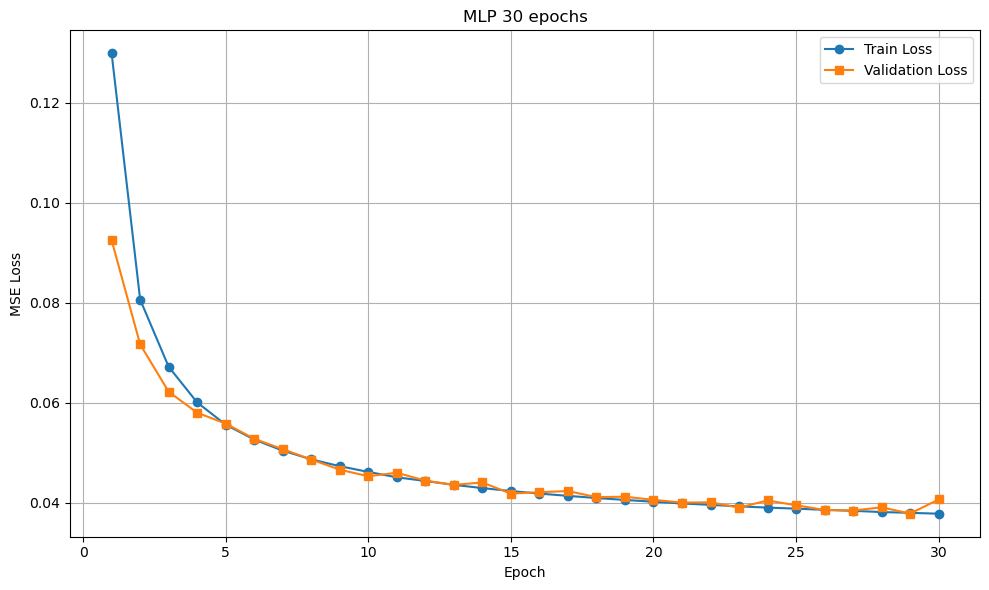

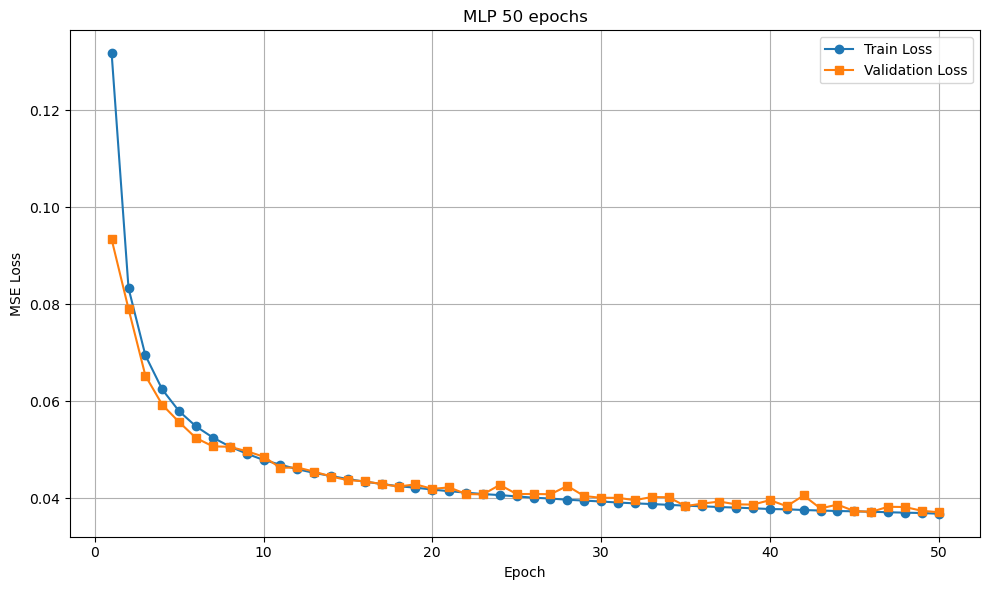

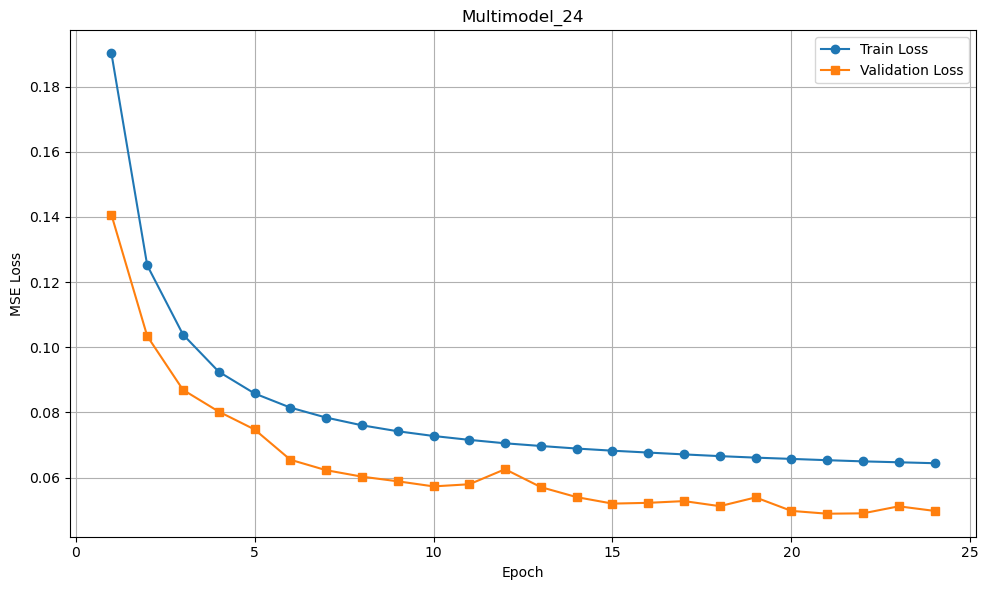

In [ ]:
def show_me(train_losses, val_losses, title : str):
    plt.figure(figsize=(10,6))
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs, val_losses,   label="Validation Loss", marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.savefig('Train_vs_Validation_Loss.png', dpi=300)
    plt.tight_layout()
    plt.show()

show_me(train_losses_MLP_30epc, val_losses_MLP_30epc, "MLP 30 epochs")
show_me(train_losses_MLP_50epc, val_losses_MLP_50epc, "MLP 50 epochs")
show_me(train_losses_Multimodel_24epochs, val_losses_Multimodel_24epochs, "Multimodel_24")
show_me(train_losses_multi_opti_30epcs, test_losses_multi_opti_30epcs, "Multimodel_opti_30")

## General Metrics

In [8]:
mae_list  = [20.7183, 19.9492, 24.5641, 20.5281]
rmse_list = [32.0403, 29.8818, 38.1646, 34.9109]
r2_list   = [0.9592, 0.9422, 0.9084, 0.9500]

metrics = ["MAE", "RMSE", "R2"]
models  = ["MLP_30epch", "MLP_50epch", "MLP_30epch_filtered", "Multi_model"]

df_results = pd.DataFrame(index=metrics, columns=models)

df_results.loc["MAE"]  = mae_list
df_results.loc["RMSE"] = rmse_list
df_results.loc["R2"]   = r2_list

df_results

,MLP_30epch,MLP_50epch,MLP_30epch_filtered,Multi_model
MAE,20.7183,19.9492,24.5641,20.5281
RMSE,32.0403,29.8818,38.1646,34.9109
R2,0.9592,0.9422,0.9084,0.95


In [13]:
model.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    y_pred_scaled = model(X_test_t).cpu().numpy()

# # voltar para escala original das strains
# y_test_real = scaler_y.inverse_transform(y_test)
# y_pred_real = scaler_y.inverse_transform(y_pred_scaled)

y_pred_real = scaler_y.inverse_transform(y_pred_scaled)
y_test_real = scaler_y.inverse_transform(y_test_scaled)

# métricas globais
mae_global  = mean_absolute_error(y_test_real, y_pred_real)
rmse_global = mean_squared_error(y_test_real, y_pred_real, squared=False)
r2_global   = r2_score(y_test_real, y_pred_real)

print("Overall metrics in the test set:")
print(f"MAE  : {mae_global:.4f}")
print(f"RMSE : {rmse_global:.4f}")
print(f"R²   : {r2_global:.4f}")

Overall metrics in the test set:
MAE  : 19.9036
RMSE : 30.5124
R²   : 0.9628


In [14]:
metrics_per_flight = {}
unique_flights = np.unique(ids_test)

for flight in unique_flights:
    mask = (ids_test == flight)
    y_true_f = y_test_real[mask]
    y_pred_f = y_pred_real[mask]

    mae  = mean_absolute_error(y_true_f, y_pred_f)
    rmse = mean_squared_error(y_true_f, y_pred_f, squared=False)
    r2   = r2_score(y_true_f, y_pred_f)

    metrics_per_flight[flight] = {"MAE": mae, "RMSE": rmse, "R2": r2}

for flight, m in metrics_per_flight.items():
    print(f"{flight}: MAE={m['MAE']:.4f}, RMSE={m['RMSE']:.4f}, R²={m['R2']:.4f}")

mae_mean  = np.mean([m["MAE"]  for m in metrics_per_flight.values()])
rmse_mean = np.mean([m["RMSE"] for m in metrics_per_flight.values()])
r2_mean   = np.mean([m["R2"]   for m in metrics_per_flight.values()])

print("\nAverage metrics across all TOLs (test):")
print(f"MAE médio  : {mae_mean:.4f}")
print(f"RMSE médio : {rmse_mean:.4f}")
print(f"R² médio   : {r2_mean:.4f}")

TOL_1: MAE=17.2699, RMSE=25.2152, R²=0.9672
TOL_10: MAE=18.0366, RMSE=26.1755, R²=0.9383
TOL_11: MAE=18.8595, RMSE=29.6737, R²=0.9328
TOL_12: MAE=23.1074, RMSE=35.2662, R²=0.9302
TOL_13: MAE=19.4904, RMSE=26.3868, R²=0.9537
TOL_14: MAE=22.9576, RMSE=34.9034, R²=0.9470
TOL_15: MAE=24.6398, RMSE=36.3449, R²=0.9478
TOL_17: MAE=18.9167, RMSE=26.4841, R²=0.9585
TOL_18: MAE=24.7793, RMSE=39.4812, R²=0.9207
TOL_19: MAE=19.9265, RMSE=30.7679, R²=0.9370
TOL_2: MAE=15.6402, RMSE=23.0699, R²=0.9483
TOL_20: MAE=24.0251, RMSE=34.7997, R²=0.9323
TOL_21: MAE=17.0795, RMSE=25.3150, R²=0.9617
TOL_22: MAE=14.3607, RMSE=19.8138, R²=0.8980
TOL_23: MAE=17.1537, RMSE=27.2600, R²=0.9319
TOL_24: MAE=17.3238, RMSE=24.9202, R²=0.9417
TOL_25: MAE=17.1161, RMSE=25.1042, R²=0.9645
TOL_26: MAE=22.5700, RMSE=36.3205, R²=0.9527
TOL_27: MAE=19.9527, RMSE=29.4973, R²=0.9051
TOL_28: MAE=20.9719, RMSE=32.1533, R²=0.9331
TOL_29: MAE=20.5433, RMSE=30.8123, R²=0.9357
TOL_3: MAE=14.3526, RMSE=20.0619, R²=0.9688
TOL_30: MAE=1

In [15]:
df_flights = pd.DataFrame.from_dict(metrics_per_flight, orient='index')

# adicionar as métricas globais
df_global = pd.DataFrame({
    "MAE":  [mae_global],
    "RMSE": [rmse_global],
    "R2":   [r2_global]
}, index=["GLOBAL"])

# concatenar tudo
df_results = pd.concat([df_flights, df_global])



In [16]:
df_results.to_csv('df_results_all_50epch.csv')

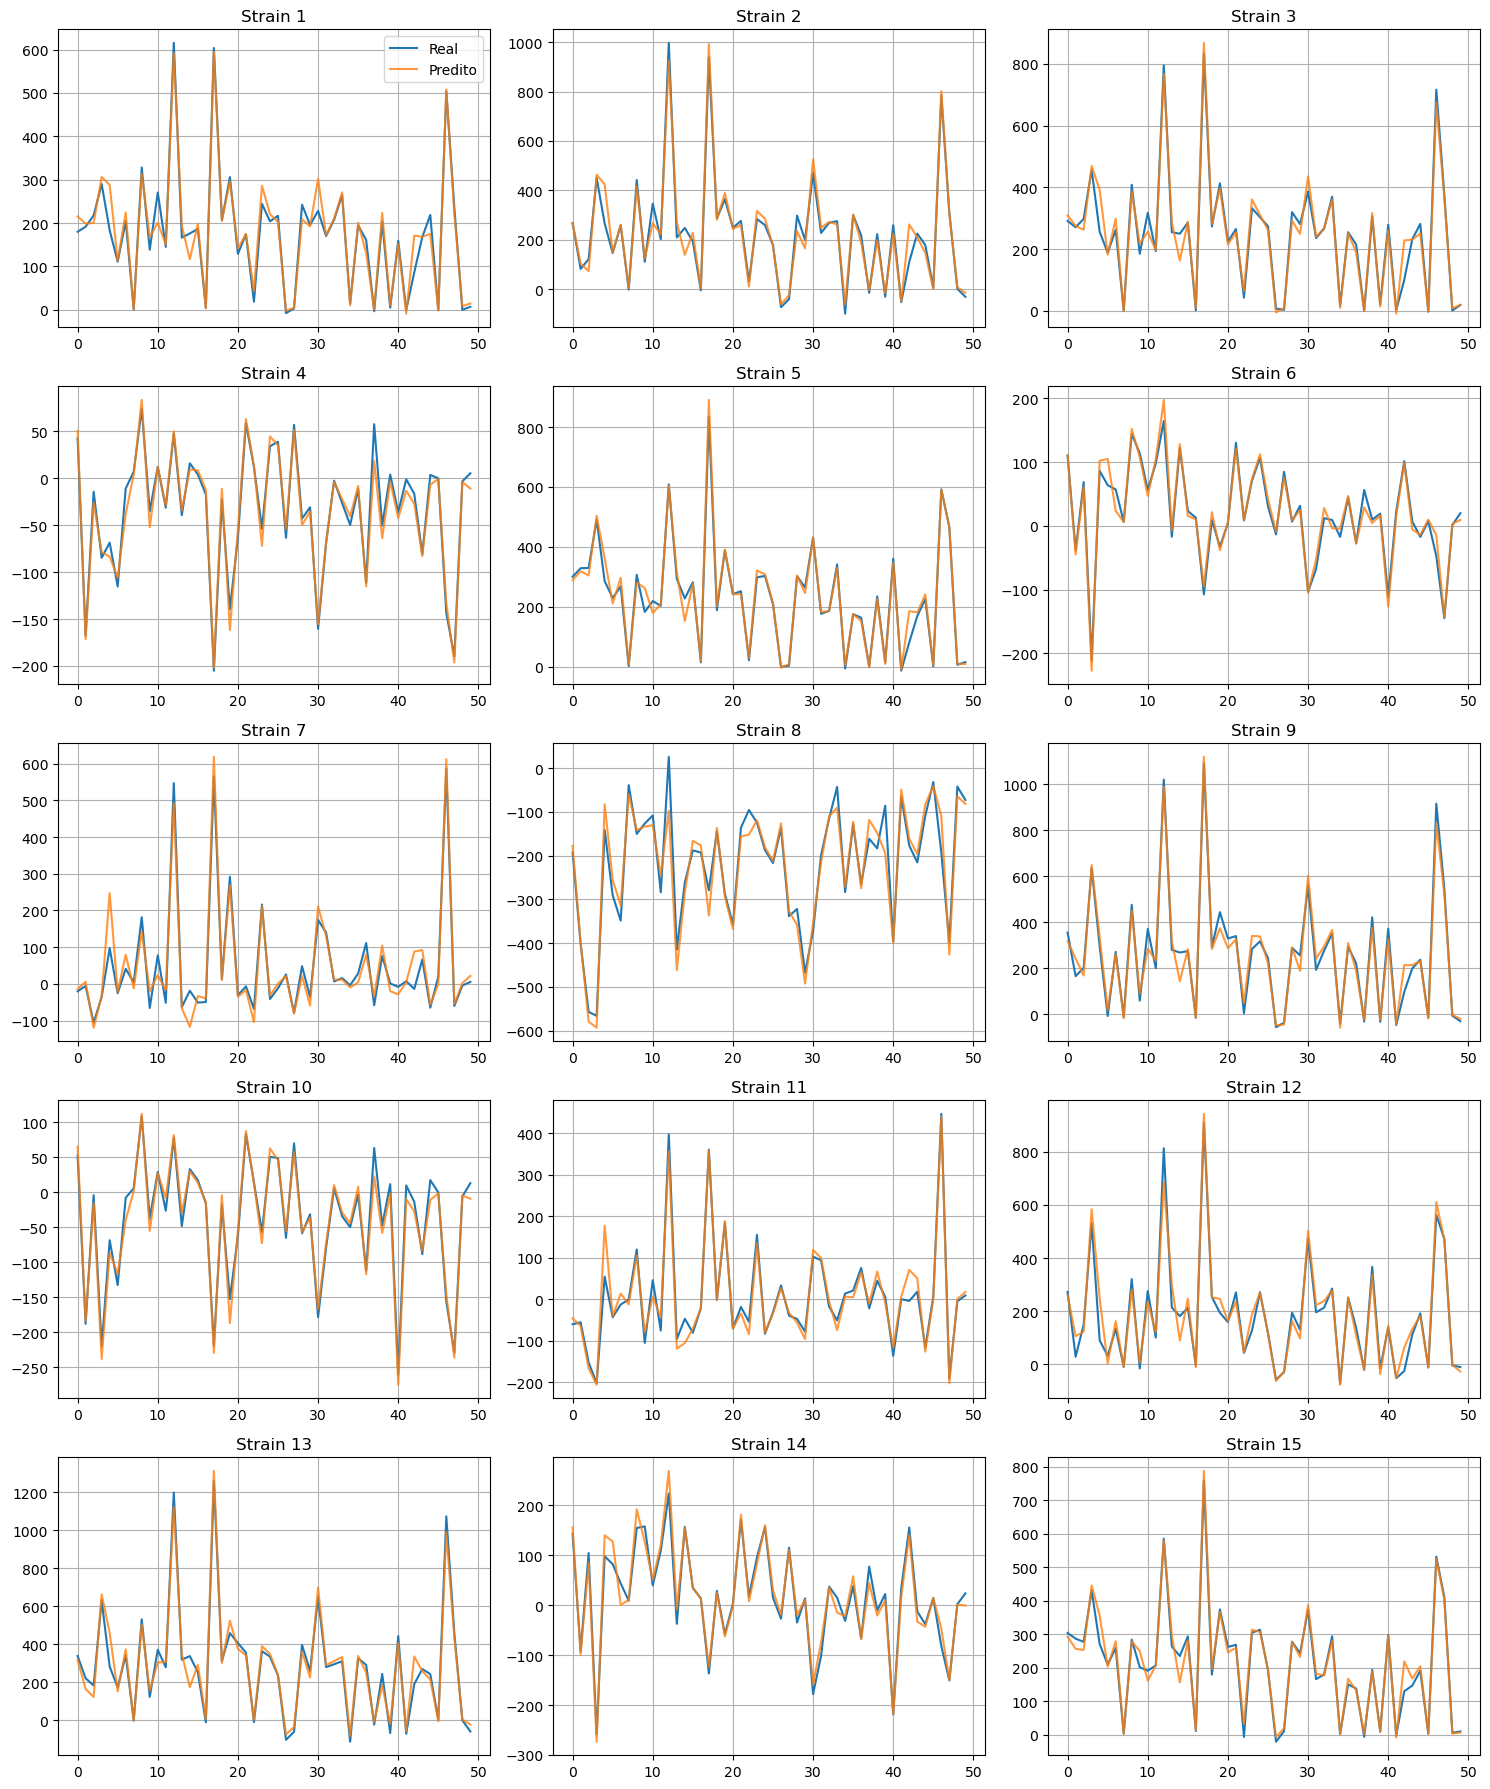

In [18]:
N = 50  # Number of point in the x axis

plt.figure(figsize=(15, 18))

for i in range(15):
    plt.subplot(5, 3, i + 1)
    plt.plot(y_test_real[:N, i], label="Real")
    plt.plot(y_pred_real[:N, i], label="Predito", alpha=0.8)
    plt.title(f"Strain {i+1}")
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()